<a href="https://colab.research.google.com/github/TillFalko/AI-Author/blob/master/Football.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


torch.manual_seed(123)


### LOAD DATA
# LETZTE SAISON
b11 = pd.read_csv('/content/drive/MyDrive/colab_data/football/Bundesliga1-20&21.csv', parse_dates=['Date'])
b12 = pd.read_csv('/content/drive/MyDrive/colab_data/football/Bundesliga2-20&21.csv', parse_dates=['Date'])
# VORLETZTE SAISON
b21 = pd.read_csv('/content/drive/MyDrive/colab_data/football/Bundesliga1-19&20.csv', parse_dates=['Date'])
b22 = pd.read_csv('/content/drive/MyDrive/colab_data/football/Bundesliga2-19&20.csv', parse_dates=['Date'])


data = pd.concat([b11, b12, b21, b22])
data = data.sort_values(by=['Date', 'Time'],ignore_index=1)

# REMOVING UNECESSARY COLUMNS
for key in data.keys():
  if key not in ['Date','Time','HomeTeam','AwayTeam','FTR']:
    del data[key]


# DIGITIZING MATCH OUTCOME -> HOMETEAM: 0, DRAW: 1, AWAYTEAM: 2.
for i in range(len(data['FTR'])):
  if data['FTR'][i] == 'H':
    data['FTR'].at[i] = 0
  elif data['FTR'][i] == 'D':
    data['FTR'].at[i] = 1
  elif data['FTR'][i] == 'A':
    data['FTR'].at[i] = 2


# SHUFFLING AND SPLITTING DATA
training_data = data.sample(frac=0.8)
validation_data = data.sample(frac=0.2)  

In [ ]:
# MAKE TEAM INDICES
team_dict = {}

id = 0
teams = data['HomeTeam']
teams.append(data['AwayTeam'])
for team in teams:
  if not team in team_dict.keys():
    team_dict[team] = id
    id += 1
del teams

In [ ]:
embed_depth = 19
class Netz(nn.Module):
  def __init__(self):
    super().__init__()
    self.embedding = nn.Embedding(
        len(team_dict.keys()),
        embed_depth)
    self.bl = nn.Bilinear(in1_features=embed_depth, in2_features=embed_depth, out_features=3, bias=False)
    self.activation = nn.Sigmoid()

  def forward(self, home_team, away_team):
    home_team = torch.tensor([team_dict[home_team]])
    home_embed = self.embedding(home_team)
    
    away_team = torch.tensor([team_dict[away_team]])
    away_embed = self.embedding(away_team)

    t = self.bl(home_embed, away_embed)
    t = self.activation(t)
    return t

In [ ]:
n = Netz()
#optimizer = optim.SGD(n.parameters(), lr=0.01, momentum=0.01)
optimizer = optim.Adam(n.parameters(), lr=0.006)
l_func = nn.CrossEntropyLoss()
losses = []

77.2062350119904


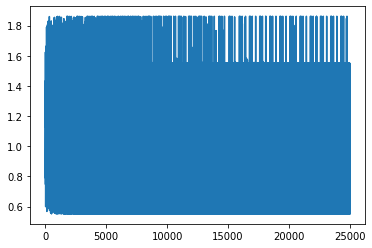

In [ ]:
# TRAINING 
correct = 0
wrong = 0
for i in range(10):
  for sample in training_data.itertuples():
    n.zero_grad()
    _, _, _, home_team, away_team, result = sample
    result = torch.tensor([result])
    prediction = n(home_team, away_team)
    loss = l_func(prediction, result)
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    if torch.argmax(prediction) == result:
      correct += 1
    else:
      wrong += 1
print(100*correct / (correct+wrong))
plt.plot(losses)
plt.show()

In [ ]:
# VALIDATION
losses = []
correct = 0
wrong = 0
for sample in validation_data.itertuples():
  _, _, _, home_team, away_team, result = sample
  result = torch.tensor([result])
  prediction = n(home_team, away_team)
  loss = l_func(prediction, result)
  losses.append(loss.item())
  optimizer.step()
  if torch.argmax(prediction) == result:
    correct += 1
  else:
    wrong += 1
print(f"{100*correct / (correct+wrong)}% correct.")
print(f"Average loss: {sum(losses)/len(losses)}")


67.78846153846153% correct.
Average loss: 0.8526111583297069


In [ ]:
a = n('Sandhausen', 'Fortuna Dusseldorf')
print(a)
print(torch.argmax(a))
print(a[0][0] - a[0][1])

tensor([[6.4995e-01, 1.0000e+00, 1.3938e-11]], grad_fn=<SigmoidBackward>)
tensor(1)
tensor(-0.3501, grad_fn=<SubBackward0>)


In [ ]:
# COUNT MATCHES FOR EACH TEAM
print(len(team_dict.keys()))
print(pd.concat([data['HomeTeam'],data['AwayTeam']]).value_counts())

38
Freiburg              58
Greuther Furth        58
Hamburg               58
Sandhausen            58
Dortmund              58
FC Koln               58
Augsburg              58
Ein Frankfurt         58
Leverkusen            58
Bayern Munich         58
Nurnberg              58
Holstein Kiel         58
Bochum                58
RB Leipzig            58
Heidenheim            58
Paderborn             58
Mainz                 58
Stuttgart             58
Schalke 04            58
Karlsruhe             58
Erzgebirge Aue        58
Hannover              58
Wolfsburg             58
Union Berlin          58
Darmstadt             58
Fortuna Dusseldorf    58
Hertha                58
Hoffenheim            58
St Pauli              58
M'gladbach            58
Osnabruck             57
Regensburg            57
Werder Bremen         57
Bielefeld             57
Dresden               34
Wehen                 34
Wurzburger Kickers    24
Braunschweig          24
dtype: int64
